In [17]:
import pandas as pd
import numpy as np

from transplant.data.dataset import Dataset
from transplant.config import *
from transplant.visualization.graph import plot_dynamic_features

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
%matplotlib inline

In [18]:
dataset = Dataset()
dataset.time_offset = 0 
train, test = dataset.get_dynamic()
df_dynamic = pd.concat([train, test])
df_dynamic.reset_index(inplace=True, drop=True) # before PR to fix bad index

In [61]:
plot_dynamic_features(df_dynamic, id_patient=369, 
                      features_list=['PAPmoy', 'PASm'],
                      display_declampage=True)

On peut voir des pics pour les valeurs de `PAPmoy` & `PASm`. 

Le problème c'est qu'il est très compliqué et long à détecté de visu / à la main par des seuils ou autres.

Au lieu de vouloir retoucher les données pour les améliorer au risque de toucher à choses bien trop sensible (perte d'information). Pourquoi ne pas donner à l'algo le risque que cette données soient fausses / mauvaises / bizarres. Il fera le boulot pour nous au moins pour certaines variables.

In [46]:
import numpy as np

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

rng = np.random.RandomState(42) 

In [47]:
## FUNCTIONS

def create_bool_ano_on_feature(df_dynamic, features_to_analyse, contamination=0.01):
    """
    Create a new feature : features_to_analyse's name with "_anomaly"
    This feature is a bool : 1 -> OK / -1 -> KO (anomaly)
    Using :
        - Imputer to fillna NaN Value
        - A scaler 
        - IsolationForest to detect anomaly
    Input :
        df_dynamic [DataFrame] : dynamic data
        features_to_analyse [str] : feature's name
        contamination : threeshold of the feature. Less detect less anomaly
    return : 
        df_dynamic [DataFrame] with 1 more feature
     """

    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    scaler = StandardScaler()
    iso_forest = IsolationForest(behaviour='new', 
                                 random_state=rng,
                                 contamination=contamination)
    my_transformer = Pipeline([('imp', imputer),
                               ('scaler', scaler), 
                               ('iso', iso_forest)])

    my_transformer.fit(df_dynamic[[features_to_analyse]])

    feature_name_anomaly = features_to_analyse+"_anomaly"
    df_dynamic[feature_name_anomaly] = my_transformer.predict(df_dynamic[[features_to_analyse]]) #[1 / -1]
    return df_dynamic

In [45]:
def plot_ano_on_patient(df, id_patient=1,
                    features_to_analyse=features_to_analyse,
                    feature_ano = features_to_analyse+"_anomaly"):
    """
    
    """
    fig, ax = plt.subplots(figsize=(10,6))

    temp_df = df[df.id_patient == id_patient]

    a = temp_df[temp_df[features_to_analyse+"_anomaly"] == -1] #anomaly
    ax.plot(temp_df.index,
            temp_df[features_to_analyse],
            label = features_to_analyse)
    ax.scatter(a.index, a[features_to_analyse],
               color='red', label = 'Anomaly')
    plt.legend()
    plt.show();

### PASm :

In [55]:
features_to_analyse = "PASm"
df_dynamic = create_bool_ano_on_feature(df_dynamic, features_to_analyse)

In [56]:
# Toutes les lignes en anomalie pour cette variable
df_dynamic[df_dynamic.PASm_anomaly==-1].head()

,id_patient,time,B.I.S,BIS SR,DC,ETCO2,FC,FR,FiO2,PAPdia,PAPmoy,PAPsys,PASd,PASm,PASs,PEEPtotal,PNId,PNIm,PNIs,Pmax,Pmean,SpO2,SvO2 (m),Temp,VT,declampage_cote1_done,declampage_cote2_done,PASm_anomaly
31,1,2012-01-05 03:31:00,NaN,NaN,NaN,0.0,61,0,99,0.0,0.0,0.0,192.0,201.0,208.0,1,0.0,0.0,0.0,2,1,94,NaN,0.000000,0.0,0,0,-1
191,1,2012-01-05 06:11:00,NaN,NaN,NaN,4.1,70,15,97,16.0,27.0,40.0,0.0,216.0,0.0,4,0.0,0.0,0.0,40,15,98,NaN,37.099998,301.0,0,0,-1
382,1,2012-01-05 09:22:00,NaN,NaN,NaN,4.0,80,14,62,18.0,25.0,35.0,0.0,214.0,0.0,5,0.0,0.0,0.0,32,13,100,NaN,37.700001,424.0,1,1,-1
383,1,2012-01-05 09:23:00,NaN,NaN,NaN,3.3,83,14,62,16.0,24.0,32.0,0.0,215.0,0.0,2,0.0,0.0,0.0,26,11,100,NaN,37.700001,55.0,1,1,-1
445,1,2012-01-05 10:25:00,NaN,NaN,NaN,3.9,86,14,62,19.0,23.0,23.0,0.0,179.0,0.0,6,0.0,0.0,0.0,32,14,100,NaN,37.500000,403.0,1,1,-1


In [62]:
#df_dynamic[df_dynamic.PASm_anomaly==-1].groupby('id_patient').count()

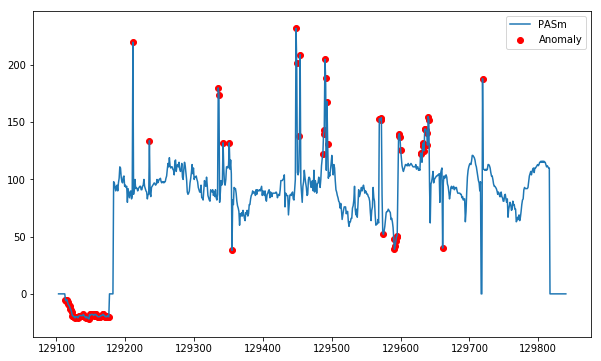

In [63]:
plot_ano_on_patient(test, id_patient=369, features_to_analyse=features_to_analyse)

### PAPmoy : 

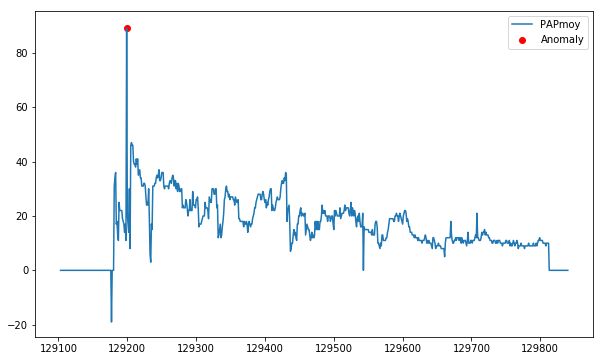

In [66]:
features_to_analyse = "PAPmoy"
df_dynamic = create_bool_ano_on_feature(df_dynamic, features_to_analyse)
plot_ano_on_patient(test, id_patient=369, features_to_analyse=features_to_analyse)

**Par la suite on peut jouer avec la variable `contamination` dans `create_bool_ano_on_feature` pour etre plus ou moins sensible au anomaly.**

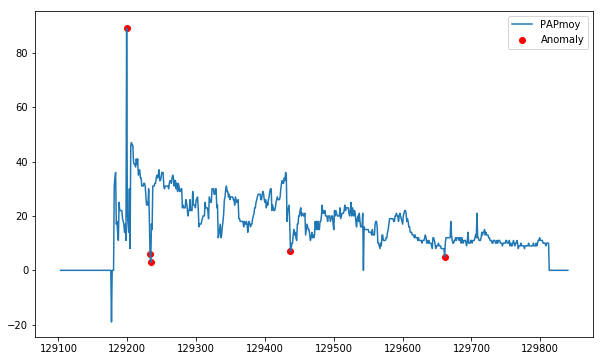

In [69]:
df_dynamic = create_bool_ano_on_feature(df_dynamic, features_to_analyse, contamination=0.03)
plot_ano_on_patient(test, id_patient=369, features_to_analyse=features_to_analyse)

## Idées et WIP

- Noter l'ensemble des variables qui assez sensibles pour ne pas risquer des perte d'informations
- Pour ces varibales trouver un seuil de sensibilité `contamination`.
- Implenter la fonction dans `dataset` ainsi que dictionnaire de configuration dans `config.py`